爆大量，超平台，當天上漲

第二步：

爆大量後回檔，超平台，當天上漲

[*********************100%%**********************]  1 of 1 completed


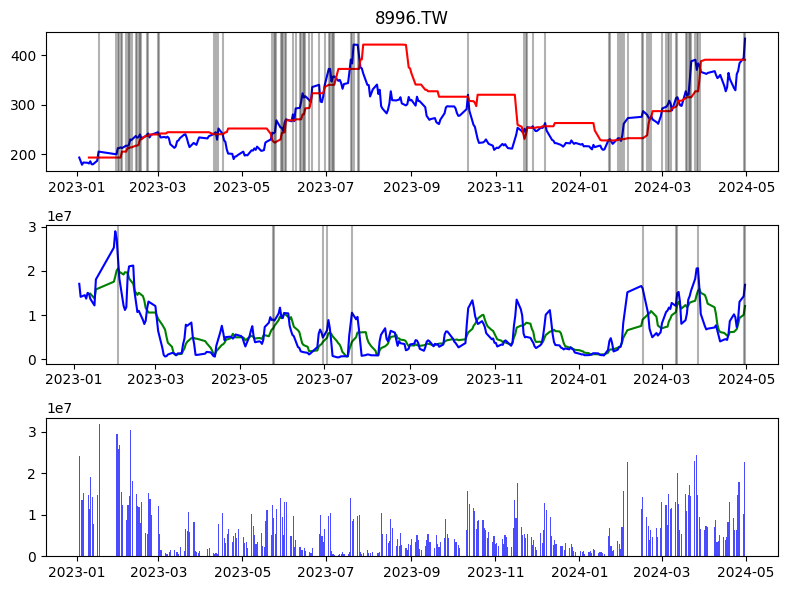

In [57]:
# 爆大量，超平台，當天上漲
import yfinance as yf
import matplotlib.pyplot as plt
stock = "8996.TW"
data = yf.download(stock, start='2023-01-01')
data['V5'] = data['Volume'].rolling(9).mean()
data['V3'] = data['Volume'].rolling(3).mean()
data['V3o5'] =  data['V3'] > data['V5']
data['returnOnClose'] = data['Close'].pct_change()
# def: 連續五天v3 > v5

# print(consecutive_false_indices)
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].plot(data['Close'], color='blue', label='Close Price')
# ax[1].plot(data['Volume'], color='red', label='Volume')
ax[1].plot(data['V5'], color='green', label='avg20vol')
ax[1].plot(data['V3'], color='blue', label='avg20vol')



# huge volume

# break the correction stage
data['price_max20'] = data['Close'].rolling(window=20, min_periods=1).max()
data['price_max20_late5'] = data['price_max20'].shift(5)

data['signal_price'] = data['price_max20_late5'] < data['Close']
data['signal_vol'] = data['V3o5'].rolling(window=5, min_periods=1).apply(lambda x: all(x == True))
data['signal_return'] = data['returnOnClose'] > 0

data['signal_total'] = (data['signal_price'] == True) & (data['signal_vol'] == True) & (data["signal_return"] == True)

ax[0].plot(data['price_max20_late5'], color="r", label='max_plate')
for dates in data[data['signal_price'] == 1].index:
    ax[0].axvline(dates, color='black', alpha=0.3)

for dates in data[data['signal_total'] == 1].index:
    ax[1].axvline(dates, color='black', alpha=0.3)

volume = data['Volume']
ax[2].bar(volume.index, volume, color='blue', alpha=0.7)
ax[0].set_title(stock)
plt.tight_layout()
plt.show()


In [32]:
import pandas as pd

# Sample DataFrame
data = {'A': [True, False, False, False, True, False, False, False, False, True]}
df = pd.DataFrame(data)

# Create a boolean mask for consecutive False values
consecutive_false_mask = (df['A'] == False) & (df['A'].shift(-1) == False) & (df['A'].shift(-2) == False)
print(consecutive_false_mask)
# Find indices where consecutive False values occur
consecutive_false_indices = consecutive_false_mask[consecutive_false_mask].index

# Print the indices of consecutive False values
print("Indices of consecutive False values:")
print(consecutive_false_indices)

# Output the rows where consecutive False values occur
print("\nRows where consecutive False values occur:")
print(df.loc[consecutive_false_indices])


0    False
1     True
2    False
3    False
4    False
5     True
6     True
7    False
8    False
9    False
Name: A, dtype: bool
Indices of consecutive False values:
Index([1, 5, 6], dtype='int64')

Rows where consecutive False values occur:
       A
1  False
5  False
6  False


In [24]:
import pandas as pd

# Sample DataFrame
data = {'A': [True, False, False, False, True, False, False, False, False, True]}
df = pd.DataFrame(data)

# Define the number of consecutive False values to check for
num_consecutive = 3

# Create a boolean mask for consecutive False values
consecutive_false_mask = df['A'].rolling(window=num_consecutive, min_periods=1).apply(lambda x: all(x == False))

# Find indices where 20 consecutive False values occur
consecutive_false_indices = consecutive_false_mask[consecutive_false_mask].index

# Print the indices of consecutive False values
print("Indices of 20 consecutive False values:")
print(consecutive_false_indices)

# Output the rows where 20 consecutive False values occur
print("\nRows where 20 consecutive False values occur:")
print(df.loc[consecutive_false_indices])


Indices of 20 consecutive False values:
Index([0, 0, 0, 1, 0, 0, 0, 1, 1, 0], dtype='int64')

Rows where 20 consecutive False values occur:
       A
0   True
0   True
0   True
1  False
0   True
0   True
0   True
1  False
1  False
0   True
